<a href="https://colab.research.google.com/github/JManuelRG/propiedades_termodinamicas/blob/main/Mezclas/Diagrama_de_Fases_Ideal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagrama de Fases Binario Ideal

#  Instrucciones: Ejecuta la siguientes celdas

# Herramienta de Web Scrapper.
ejecuta la siguiente función

#Ecuación de Antoine
# Contantes Obtenidas de la base de datos web de NIST:

https://webbook.nist.gov/chemistry/

In [2]:
# Importar la función get del módulo requests porque es la función encargada de
# hacer la solicitud HTTP GET con la URL proporcionada.
from requests import get

# Importar BeautifulSoup de bs4 porque hace el análisis HTML y nos ayuda a
# manejar el DOM.
from bs4 import BeautifulSoup

# Importar closing para asegurar que cualquier recurso de red se libere cuando
# salga de alcance.
from contextlib import closing

def get_antoine_coef(Nombre, Temperatura):

    """ Devuelve una lista con los coeficientes A, B y C si existen para la
        Temperatura dada. Si no, retorna None e imprime un mensaje.

    :param Nombre:
        Una cadena con el nombre del compuesto en inglés.

    :param Temperatura:
        Un número flotante con la temperatura en Kelvin.

    :rtype: Lista

    :return coef con [A, B, C]

    """

    # Obteniendo la tabla usando la función get_html mostrada abajo. Table es un
    # Objeto BeautifulSoup.
    tabla = get_html_table(Nombre)

    # Extraer las filas de la tabla. Sabiendo qué etiquetas tiene una tabla HTML.
    # Además, sabiendo que la primera fila con el encabezado de la tabla no tiene el
    # atributo de clase 'exp' así que obtenemos solo las filas con datos.
    # La función find_all de BeautifulSoup devuelve una lista.
    filas = tabla.find_all('tr', class_='exp')

    # Declarar las listas para almacenar Temperaturas y coeficientes.
    Temperaturas, As, Bs, Cs = [], [], [], []

    # Iterando sobre las filas para extraer y llenar las variables As, Bs y Cs porque ahora
    # estamos seguros de que las Temperaturas están entre algún rango.
    for fila in filas:

        # Como las filas, extraemos las columnas para la fila actual. Sabiendo que
        # las columnas tienen la etiqueta <td> en HTML también.
        # La función find_all de BeautifulSoup devuelve una lista.
        cols =  fila.find_all('td')

        # Primero transformamos las cadenas en números flotantes y las colocamos en su
        # respectiva lista.
        As.append(float(cols[1].text))
        Bs.append(float(cols[2].text))
        Cs.append(float(cols[3].text))

        # Para las temperaturas, tenemos un rango y necesitamos extraer cada
        # límite (inferior y superior) y colocarlos en una lista adicional. Así que
        # la variable Temperatures será una lista de listas.
        limite_inferior = float(cols[0].text.replace(" ","").split('-')[0])
        limite_superior = float(cols[0].text.replace(" ","").split('-')[1])
        Temperaturas.append([limite_inferior, limite_superior])


    # Verificar si la Temperatura dada se encuentra en algún intervalo
    indice = None
    for i, intervalo in enumerate(Temperaturas):
        if (intervalo[0] <= Temperatura
            and Temperatura <= intervalo[1]):
            indice = i
            break
        else:
            indice = None

    if indice == None:
        print('Lo siento, los datos para la temperatura dada %.2f K no existen en la Base de Datos' % Temperatura)
        return None
    else:
        A = As[indice]
        B = Bs[indice]
        C = Cs[indice]
        return [A, B, C]


def get_html_table(Nombre):

    """ Retorna el HTML ya parseado usando una función auxiliar listada abajo.

    :param Nombre:
        Una cadena con el nombre del compuesto en inglés.

    :rtype: Objeto BeautifulSoup

    """

    # El parámetro name es parte de la URL. Por ejemplo, si deseas los
    # datos de metano, la URL es
    # https://webbook.nist.gov/cgi/cbook.cgi?Name=methane&Mask=4.
    url = str.format('https://webbook.nist.gov/cgi/cbook.cgi?Name={0}&Mask=4', Nombre.lower())

    # Función para obtener la solicitud realizada, ver más abajo.
    html_bruto = get_response(url)

    # Parsear el HTML usando BeautifulSoup.
    html = BeautifulSoup(html_bruto, 'html.parser')

    # Extraer la tabla que contiene los datos, la tabla tiene un
    # atributo específico 'aria-label' como 'Antoine Equation Parameters'.
    tabla = html.find('table', attrs={'aria-label': 'Antoine Equation Parameters'})

    return tabla


def get_response(url):

    """ Retorna el HTML sin procesar para analizarlo más tarde o None si no se puede acceder a la página.

    :param url:
        La cadena para la solicitud GET.

    :rtype: Objeto BeautifulSoup

    :rtype: None si no se puede acceder al sitio web

    """

    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except:
        print('No encontrado')
        return None


def is_good_response(resp):
    """
    Retorna True si la respuesta parece ser HTML, False en caso contrario.
    """
    tipo_contenido = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200
            and tipo_contenido is not None
            and tipo_contenido.find('html') > -1)

# Forma de la ec. de Antoine

$$log_{10}(P) = A −\frac{B}{T+C}$$

P = Presión de vapor (bar),  T = temperatura (K)

## Constantes de Antoine: Compuesto 1

In [14]:
import pandas as pd
# Obtener las variables de la ecuación de Antoine
print("Constantes de la Ec. de Antoine:")
nombre1 = input('Escribe el nombre del compuesto 1 en inglés: ')
T1 = float(input('Escribe la temperatura promedio del compuesto, K: '))
A1,B1,C1 = get_antoine_coef(nombre1,
                  T1)
print(f'Tabla de constantes de Antoine para -{nombre1}-, válidos a una temperatura de {T1} Kelvin')
print('Obtenidos de la base de Datos NIST:')
print(f'URL = https://webbook.nist.gov/cgi/cbook.cgi?Name={nombre1}&Mask=4')
datosAntoine = pd.DataFrame({'Compuesto':nombre1,
                             'A':[A1],
                             'B':[B1],
                             'C':[C1]})
datosAntoine.set_index('Compuesto')

Constantes de la Ec. de Antoine:
Escribe el nombre del compuesto 1 en inglés: methanol
Escribe la temperatura promedio del compuesto, K: 500
Tabla de constantes de Antoine para -methanol-, válidos a una temperatura de 500.0 Kelvin
Obtenidos de la base de Datos NIST:
URL = https://webbook.nist.gov/cgi/cbook.cgi?Name=methanol&Mask=4


,A,B,C
Compuesto,,,
methanol,5.15853,1569.613,-34.846


# Constantes de Antoine: Compuesto 2

In [15]:
# Obtener las variables de la ecuación de Antoine
print("Constantes de la Ec. de Antoine:")
nombre2 = input('Escribe el nombre del compuesto en inglés: ')
T2 = float(input('Escribe la temperatura promedio del compuesto, K: '))
A2,B2,C2 = get_antoine_coef(nombre2,
                  T2)
print(f'Tabla de constantes de Antoine para -{nombre2}-, válidos a una temperatura de {T2} Kelvin')
print('Obtenidos de la base de Datos NIST:')
print(f'URL = https://webbook.nist.gov/cgi/cbook.cgi?Name={nombre2}&Mask=4')
datosAntoine2 = pd.DataFrame({'Compuesto':nombre2,
                             'A':[A2],
                             'B':[B2],
                             'C':[C2]})
datosAntoine2.set_index('Compuesto')

Constantes de la Ec. de Antoine:
Escribe el nombre del compuesto en inglés: water
Escribe la temperatura promedio del compuesto, K: 400
Tabla de constantes de Antoine para -water-, válidos a una temperatura de 400.0 Kelvin
Obtenidos de la base de Datos NIST:
URL = https://webbook.nist.gov/cgi/cbook.cgi?Name=water&Mask=4


,A,B,C
Compuesto,,,
water,3.55959,643.748,-198.043


# Generación del diagrama de fases binario ideal:

# La herramienta puede generar el diagrama Pxy o Txy

# Ejecutar la siguiente celda:

CONSTRUCCIÓN DE DIAGRAMAS TERMODINÁMICOS DE EQUILIBRIO LÍQUIDO-VAPOR PARA MEZCLAS BINARIAS.
ENTRADA: Componentes, Unidades de T y P, valor de T para el diagrama P-x-y y valor de P para el diagrama T-x-y.
SALIDA: Diagrama de equilibrio T-x-y a Pcte y Diagrama de Equilibrio P-x-y a Tcte en formato png.
Vectores con los datos tabulados almacenados como variables.

VALORES DE ENTRADA PARA LA CONSTRUCCIÓN DEL DIAGRAMA P-x-y
Escribe el valor de la temperatura constante del sistema T(°C) =400

VALORES DE ENTRADA PARA LA CONSTRUCCIÓN DEL DIAGRAMA T-x-y
Escribe el valor de la presión constante del sistema P(kPa) =200000


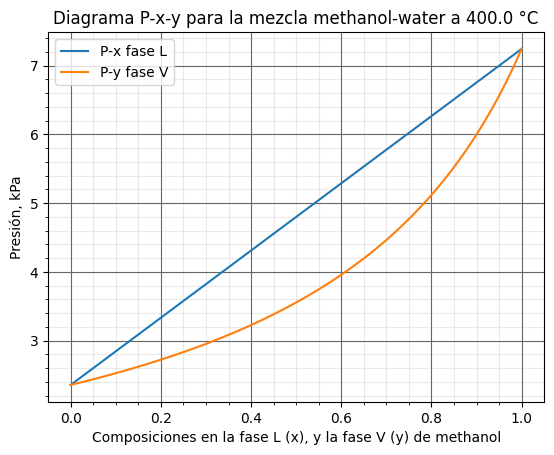

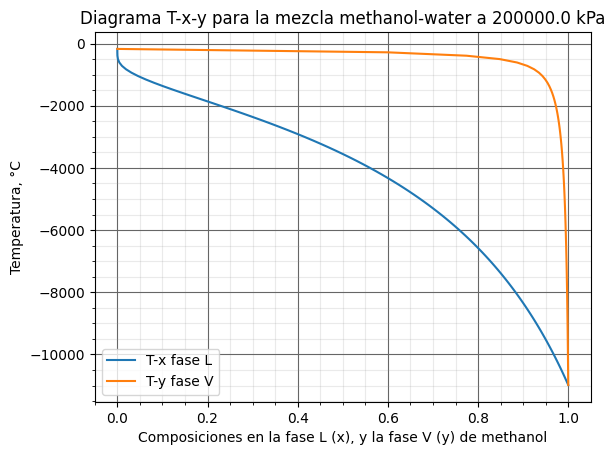


Salida del Programa:
Guarde sus gráficos haciendo click derecho y guardar 


<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt #Librería de graficación
from math import log10 #Importar Logaritmo de Librería matemática
import numpy as np #Librería numérica

#Encabezado
print("CONSTRUCCIÓN DE DIAGRAMAS TERMODINÁMICOS DE EQUILIBRIO LÍQUIDO-VAPOR PARA MEZCLAS BINARIAS.")

print("ENTRADA: Componentes, Unidades de T y P, valor de T para el diagrama P-x-y y valor de P para el diagrama T-x-y.")
print("SALIDA: Diagrama de equilibrio T-x-y a Pcte y Diagrama de Equilibrio P-x-y a Tcte en formato png.")
print("Vectores con los datos tabulados almacenados como variables.")

# Definir unidades de medición
unit="°C"
unip="kPa"

# Definir modelos de la ec. de Antoine
def psat(A,B,C,T):
	p = 10**(A-B/(T+C))
	return p

def tsat(A,B,C,P):
	tempsat = B/(A-log10(P))-C
	return tempsat


#Diagrama de Pxy
print("\nVALORES DE ENTRADA PARA LA CONSTRUCCIÓN DEL DIAGRAMA P-x-y")
Tpxy=float(input(f"Escribe el valor de la temperatura constante del sistema T({unit}) ="))
n=100 #Num de puntos a calcular
#Crear vectores de composiciones en la fase líquida
xp1=np.linspace(0,1,n)
xp2=1-xp1
L=len(xp1) #Num de elementos en xp1
#Inicializar vectores de Presión y composición en la fase vapor
Pxy=[0]*L
yp1=[0]*L
yp2=[0]*L
#Calcular valores de Psat de cada componente
Psat1=psat(A1,B1,C1,Tpxy)
Psat2=psat(A2,B2,C2,Tpxy)
#Generar Valores de Presión del sistema L-V
for i in range(n):
  Pxy[i]=xp1[i]*Psat1+xp2[i]*Psat2
  yp1[i]=xp1[i]*Psat1/Pxy[i]
  yp2[i]=1-yp1[i]

#Variables a graficar
#xp1 vs Pxy y yp1 vs Pxy

#Gráfico Txy
print("\nVALORES DE ENTRADA PARA LA CONSTRUCCIÓN DEL DIAGRAMA T-x-y")
Ptxy=float(input(f"Escribe el valor de la presión constante del sistema P({unip}) ="))
Tsat1=tsat(A1,B1,C1,Ptxy)
Tsat2=tsat(A2,B2,C2,Ptxy)
#Crear vecctor temperatura
Txy=np.linspace(Tsat1,Tsat2,n)
L=len(Txy)
#Inicializar vectores de Presión
Psat1=np.zeros(L)
Psat2=np.zeros(L)
xt1=np.zeros(L)
yt1=np.zeros(L)
#Cálculo de presiBones de saturación de cada componente para cada valor de temperatura
for i in range(n):
    Psat1[i]=psat(A1,B1,C1,Txy[i])
    Psat2[i]=psat(A2,B2,C2,Txy[i])
    xt1[i]=(Ptxy-Psat2[i])/(Psat1[i]-Psat2[i])
    yt1[i]=xt1[i]*Psat1[i]/Ptxy
yt2=1-yt1
xt2=1-xt1

#Variables a graficar
#xt1 vs Txy y yt1 vs Txy

#Funcion para graficar y exportar archivo como imagen png
def graficar(tipo, x1,y1,lbl1,x2,y2,lbl2):
    plt.plot(x1,y1, label=lbl1)
    plt.plot(x2,y2, label=lbl2)
    plt.xlabel(f'Composiciones en la fase L (x), y la fase V (y) de {nombre1}')
    if tipo == "P-x-y":
        plt.ylabel(f'Presión, {unip}')
        plt.title(f'Diagrama {tipo} para la mezcla {nombre1}-{nombre2} a {Tpxy} {unit}')
    elif tipo == "T-x-y":
        plt.ylabel(f'Temperatura, {unit}')
        plt.title(f'Diagrama {tipo} para la mezcla {nombre1}-{nombre2} a {Ptxy} {unip}')
    plt.legend() #Escribir Leyendas de datos
    # Mostrar líneas de cuadrícula mayores color gris oscuro
    plt.grid(True, which='major', color='#666666', linestyle='-')
    # Mostrar líneas de cuadrícula menores color gris claro
    plt.minorticks_on()
    plt.grid(True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #Exportar a archivo png de alta resolución
    if tipo == "P-x-y":
        #plt.savefig(f'Diagrama {tipo} {nombre1}-{nombre2} a {Tpxy} {unit}.png',dpi=1024)
        plt.show() #Mostrar en área de trabajo
        plt.clf() #Borrar valores de gráfico
    elif tipo == "T-x-y":
      #  plt.savefig(f'Diagrama {tipo} {nombre1}-{nombre2} a {Ptxy} {unip}.png',dpi=1024)
        plt.show() #Mostrar en área de trabajo
        plt.clf() #Borrar valores de gráfico

#Generar Gráficos
#Gráfico P-x-y
#xp1 vs Pxy y yp1 vs Pxy
graficar("P-x-y", xp1, Pxy, "P-x fase L", yp1, Pxy, "P-y fase V")

#Gráfico T-x-y
#xt1 vs Txy y yt1 vs Txy
graficar("T-x-y", xt1, Txy, "T-x fase L", yt1, Txy, "T-y fase V")

print("\nSalida del Programa:")
print("Guarde sus gráficos haciendo click derecho y guardar ")
